In [5]:
pip install numpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


# Simulations Project
## By Kaitlyn Zhou

### Introduction
Welcome to my simple simulations project! In this notebook, I will build the simulator and explain my thought process along the way.

### Initial Brainstorming and Testing
Based on the project spec, I decided that my first course of action would be to define what was given and turn them into variables. Using the variables I just defined and the useful formulas in the spec, I created functions. 

## Useful Formulas
actualF = min(appliedF, tractionF)

tractionF = μ*normalF = μmg

appliedF = motorF − resistanceF

τ = F∗r

v = ωr

x_f = x_i + v_i*t + 0.5*a_i*t^2

v_f = v_i + a*t

In [6]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# Defining constants

mass = 300       # kg
tireRad = 0.254  # m
driveRatio = 4
timeStep = 0.5   # s
mu = 1
g = 9.81         # m/s^2
curveRad = 50    # m
torqueTable = pd.read_csv('motorCurves.csv')
rpmList = torqueTable['Motor Speed (RPM)'].values
torqueList = torqueTable['Torque (Capped at 80kW) (Nm)'].values

In [8]:
# Formula functions
def actualF(appliedF, tractionF):
    return min(appliedF, tractionF)

def tractionF():
    return mu*mass*g

def appliedF(motorF, resistanceF):
    return motorF-resistanceF

def motorF(torque):
    return (torque*driveRatio)/tireRad

def getTorque(v):
    wheelRPM = (v*60)/(2*np.pi*tireRad)
    motorRPM = wheelRPM*driveRatio
    torque = np.interp(motorRPM, rpmList, torqueList)
    return torque

In [9]:
# Simulation code
def sim():
    velocity = 0
    position = 0
    time = 0

    vLog = []
    tLog = []
    xLog = []
    torqueLog = []

    while position < 500:
        # Physics calculations
        torque = getTorque(velocity)
        mF = motorF(torque)
        apF = appliedF(mF, 0)
        trF = tractionF()
        actF = actualF(apF, trF)
        a = actF/mass

        # Add data to log
        vLog.append(velocity)
        tLog.append(time)
        xLog.append(position)
        torqueLog.append(torque)

        # Update movement
        velocity += a*timeStep
        position += velocity*timeStep
        time += timeStep

    return vLog, tLog, xLog, torqueLog

Text(0.5, 1.0, 'Velocity vs Time Graph')

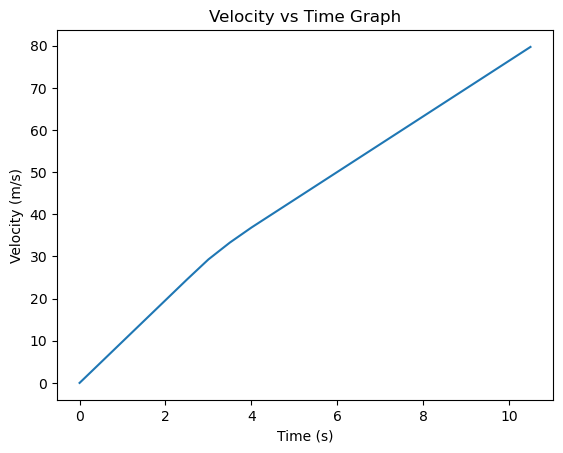

In [10]:
vData, tData, xData, torqueData = sim()
plt.plot(tData, vData)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs Time Graph")

Text(0.5, 1.0, 'Torque vs Time Graph')

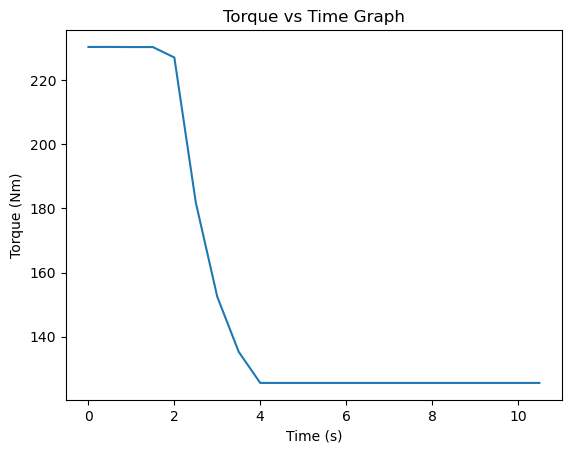

In [11]:
plt.plot(tData, torqueData)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Torque vs Time Graph")

Text(0.5, 1.0, 'Position vs Time Graph')

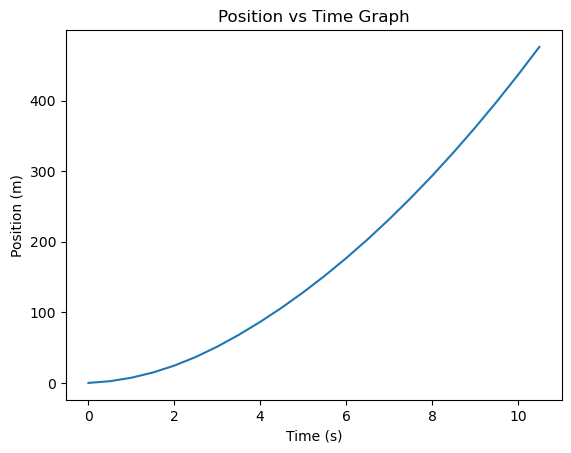

In [12]:
plt.plot(tData, xData)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time Graph")

In [22]:
'''def adjustedSim(v):
    torque = getTorque(v)
    mF = motorF(torque)
    apF = appliedF(mF, 0)
    trF = tractionF()
    actF = actualF(apF, trF)
    a = actF/mass

    stats = []
    stats.append(v)
    stats.append(t)
    stats.append(x)
    stats.append(torque)

    return stats

def jSim():
    velocity = 0
    position = 0
    time = 0

    vLog = []
    tLog = []
    xLog = []
    torqueLog = []
    
    while position < totalDist:
        if position < 500:
            vLog.append(adjustedSim(velocity, position, time)[0])
            tLog.append(adjustedSim(velocity, position, time)[1])
            xLog.append(adjustedSim(velocity, position, time)[2])
            torqueLog.append(adjustedSim(velocity, position, time)[3])
            # Update movement
            velocity += a*timeStep
            position += v*timeStep
            time += timeStep
        else:
            pass'''

# Initially I was going to compute each bend  of the track but I realized that 
# the formula requires the minimum of the velocities that are resulted by the
# straight path, normal acceleration of the curve, and normal deceleration of 
# the curve

'def adjustedSim(v):\n    torque = getTorque(v)\n    mF = motorF(torque)\n    apF = appliedF(mF, 0)\n    trF = tractionF()\n    actF = actualF(apF, trF)\n    a = actF/mass\n\n    stats = []\n    stats.append(v)\n    stats.append(t)\n    stats.append(x)\n    stats.append(torque)\n\n    return stats\n\ndef jSim():\n    velocity = 0\n    position = 0\n    time = 0\n\n    vLog = []\n    tLog = []\n    xLog = []\n    torqueLog = []\n\n    while position < totalDist:\n        if position < 500:\n            vLog.append(adjustedSim(velocity, position, time)[0])\n            tLog.append(adjustedSim(velocity, position, time)[1])\n            xLog.append(adjustedSim(velocity, position, time)[2])\n            torqueLog.append(adjustedSim(velocity, position, time)[3])\n            # Update movement\n            velocity += a*timeStep\n            position += v*timeStep\n            time += timeStep\n        else:\n            pass'

Text(0.5, 1.0, 'Final Velocity vs Time Graph')

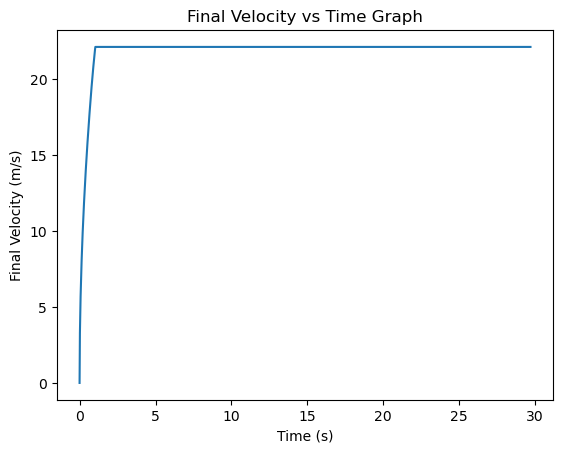

In [34]:
# Attempting the J-shaped track
totalDist = 500+(curveRad*np.pi)   # straight part + diameter of the curve
vMaxCurve = np.sqrt(g*curveRad)    # velocity from centripetal force
# ^ this is the max speed the car can go without veering off the curve

# New plan: 
'''
1. Create a table where each column corresponds to the velocity if under normal acceleration in straight line,
centripetal acceleration forward, centripetal decleration backward
2. Apply aggregate function over the columns to get the minimum velocity
3. Record results
'''
xStep = 0.5   # m
distances = np.arange(0, totalDist + xStep, xStep)
df = pd.DataFrame({'distance': distances})

def getForwardV():
    vForward = np.zeros(len(distances))
    v = 0
    for i in range(1, len(distances)):
        if distances[i] <= 500:
            # Physics calculations
            torque = getTorque(v)
            a = motorF(torque*0.9)/mass   # 0.9 is the drivetrain efficiency, a is from f=ma
            v = np.sqrt(v**2 + 2*a*xStep)
        else:
            v = v
        vForward[i] = v
    return vForward

def getBackwardV():
    vBackward = np.zeros(len(distances))
    v = vMaxCurve

    for i in range(len(distances)-1, -1, -1):
        if distances[i] > 500:
            v = vMaxCurve
        else:
            aBrake = g
            v = np.sqrt(v**2 + 2*aBrake*xStep)
        vBackward[i] = v
    return vBackward

df['motorVelocity'] = getForwardV()
df['brakeVelocity'] = getBackwardV()
df['maxApexVelocity'] = vMaxCurve
df['finalVelocity'] = df[['motorVelocity', 'brakeVelocity', 'maxApexVelocity']].min(axis=1)
df['timeStep'] = xStep/df['maxApexVelocity']
df.loc[0, 'timeStep'] = 0
df['time'] = df['timeStep'].cumsum()

plt.plot(df['time'], df['finalVelocity'])
plt.xlabel("Time (s)")
plt.ylabel("Final Velocity (m/s)")
plt.title("Final Velocity vs Time Graph")

Text(0.5, 1.0, 'Final Velocity vs Time Graph')

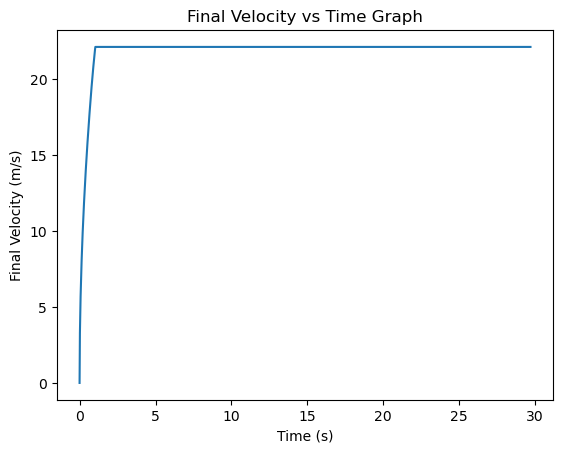

In [44]:
# Attempting the J-shaped track
totalDist = 500+(curveRad*np.pi)   # straight part + diameter of the curve
vMaxCurve = np.sqrt(g*curveRad)    # velocity from centripetal force
# ^ this is the max speed the car can go without veering off the curve

# New plan: 
'''
1. Create a table where each column corresponds to the velocity if under normal acceleration in straight line,
centripetal acceleration forward, centripetal decleration backward
2. Apply aggregate function over the columns to get the minimum velocity
3. Record results
'''
xStep = 0.5   # m
distances = np.arange(0, totalDist + xStep, xStep)
df = pd.DataFrame({'distance': distances})

def adjustSim(v):
    torque = getTorque(v)
    mF = motorF(torque)
    apF = appliedF(mF, 0)
    trF = tractionF()
    actF = actualF(apF, trF)
    a = actF/mass
    v += a*timeStep
    return v
    
def getForwardV():
    vForward = np.zeros(len(distances))
    v = 0
    for i in range(1, len(distances)):
        if distances[i] <= 500:
            # Physics calculations
            torque = getTorque(v)
            a = motorF(torque*0.9)/mass   # 0.9 is the drivetrain efficiency, a is from f=ma
            v = np.sqrt(v**2 + 2*a*xStep)
        else:
            v = v
        vForward[i] = v
    return vForward

def getBackwardV():
    vBackward = np.zeros(len(distances))
    v = vMaxCurve

    for i in range(len(distances)-1, -1, -1):
        if distances[i] > 500:
            v = adjustSim(v)
        else:
            aBrake = g
            v = np.sqrt(v**2 + 2*aBrake*xStep)
        vBackward[i] = v
    return vBackward

df['motorVelocity'] = getForwardV()
df['brakeVelocity'] = getBackwardV()
df['maxApexVelocity'] = vMaxCurve
df['finalVelocity'] = df[['motorVelocity', 'brakeVelocity', 'maxApexVelocity']].min(axis=1)
df['timeStep'] = xStep/df['maxApexVelocity']
df.loc[0, 'timeStep'] = 0
df['time'] = df['timeStep'].cumsum()

plt.plot(df['time'], df['finalVelocity'])
plt.xlabel("Time (s)")
plt.ylabel("Final Velocity (m/s)")
plt.title("Final Velocity vs Time Graph")

In [38]:
df

,distance,motorVelocity,brakeVelocity,maxApexVelocity,finalVelocity,timeStep,time
0,0.0,0.000000,1068.431732,22.147235,0.000000,0.000000,0.000000
1,0.5,3.298200,1068.427141,22.147235,3.298200,0.022576,0.022576
2,1.0,4.664187,1068.422550,22.147235,4.664187,0.022576,0.045152
3,1.5,5.712401,1068.417959,22.147235,5.712401,0.022576,0.067729
4,2.0,6.596251,1068.413368,22.147235,6.596251,0.022576,0.090305
...,...,...,...,...,...,...,...
1311,655.5,79.318039,41.808057,22.147235,22.147235,0.022576,29.597375
1312,656.0,79.318039,38.511224,22.147235,22.147235,0.022576,29.619951
1313,656.5,79.318039,35.128718,22.147235,22.147235,0.022576,29.642527
1314,657.0,79.318039,31.379692,22.147235,22.147235,0.022576,29.665103


Text(0.5, 1.0, 'Final Velocity vs Position Graph')

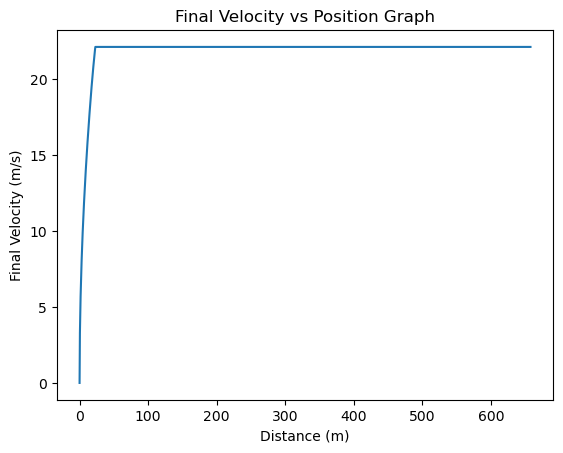

In [39]:
plt.plot(df['distance'], df['finalVelocity'])
plt.xlabel("Distance (m)")
plt.ylabel("Final Velocity (m/s)")
plt.title("Final Velocity vs Position Graph")

In [58]:
lapTime = df['time'].tolist()[len(df['time'])-1]
print("The lap time of the J-track is " + str(lapTime) + " seconds.")

The lap time of the J-track is 29.6876793948109 seconds.
